# Lesson 1 Project - Fried Chicken vs Labradoodles
For this assignment, we'll build a deep learning model which will, hopefully, succeed where others have struggled before it.  

https://twitter.com/drjuliashaw/status/874293864814845952?lang=en

https://www.linkedin.com/posts/activity-6824340683722170368-MIoy?utm_source=linkedin_share&utm_medium=member_desktop_web

https://arxiv.org/ftp/arxiv/papers/1801/1801.09573.pdf

Let's get started!

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 719 kB 33.6 MB/s 
     |████████████████████████████████| 4.2 MB 64.6 MB/s 
     |████████████████████████████████| 342 kB 62.3 MB/s 
     |████████████████████████████████| 197 kB 73.4 MB/s 
     |████████████████████████████████| 1.2 MB 56.0 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 212 kB 77.2 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 57.7 MB/s 
     |████████████████████████████████| 140 kB 79.1 MB/s 
     |████████████████████████████████| 127 kB 76.7 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 78.2 MB/s 
     |████████████████████████████████| 144 kB 75.6 MB/s 
     |████████████████████████████████| 596 kB 72.0 MB/s 
     |████████████████████████████████| 6.6 MB 61.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the 

Let's rebuild the helper function for downloading images from DuckDuckGo


In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Let's have a look at fried chicken photos

In [3]:
urls = search_images('fried chicken photos', max_images=1)
urls[0]

'https://static01.nyt.com/images/2016/06/28/dining/28COOKING-FRIEDCHICKENGUIDE13/28COOKING-FRIEDCHICKENGUIDE13-superJumbo.jpg'

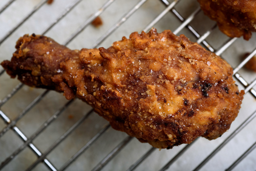

In [4]:
from fastdownload import download_url
dest = 'chicken.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now, let's have a look at a photo of a labradoodle ...

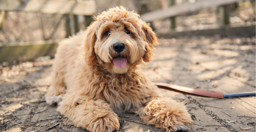

In [5]:
download_url(search_images('labradoodle photos', max_images=1)[0], 'labradoodle.jpg', show_progress=False)
Image.open('labradoodle.jpg').to_thumb(256,256)

These look like the ones that we've seen in the paper, and Twitter post, so let's have a go here ...

In [6]:
searches = 'fried chicken','labradoodle puppy'
path = Path('01_chicken_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

Let's make sure that all of our downloaded photos are valid.

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

Let's build our DataBlock!

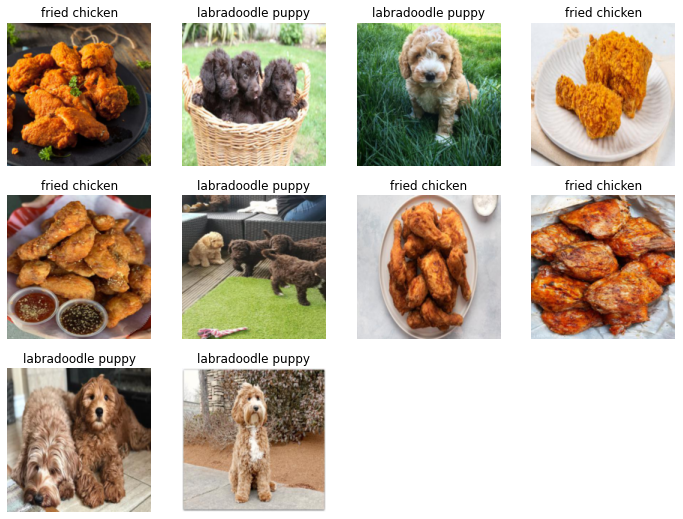

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.20, seed=42),
    get_y=parent_label,
    item_tfms=[ Resize(192, method='squish') ]
).dataloaders(path)

dls.show_batch(max_n=10)

This doesn't quite look right.  Let's see if we can get better images.

In [9]:
searches = 'crispy fried chicken','tan labradoodle puppy'
path = Path('02_chicken_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

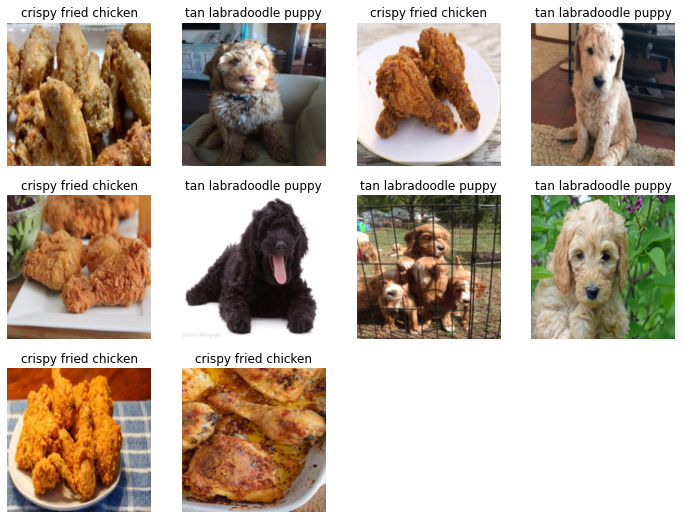

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=10)

These still aren't quite right, but let's build our model and see how it fares on some hand-picked photos.  We'll build it using both sets of images we've downloaded so far.

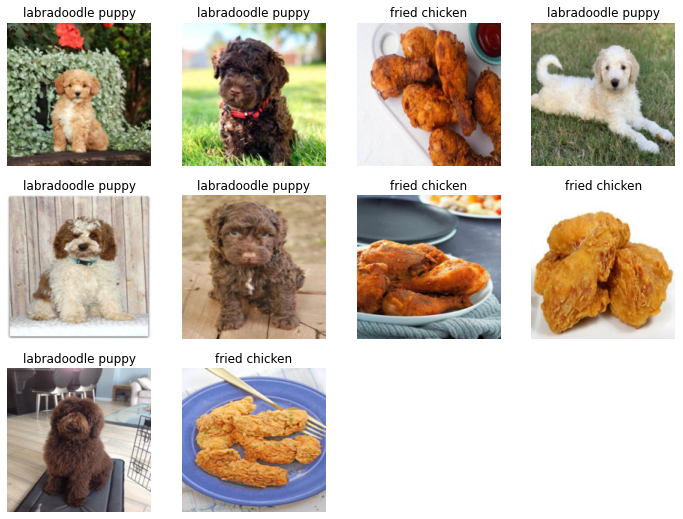

In [12]:
path1 = Path('01_chicken_or_not')

dls1 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path1)

dls1.show_batch(max_n=10)

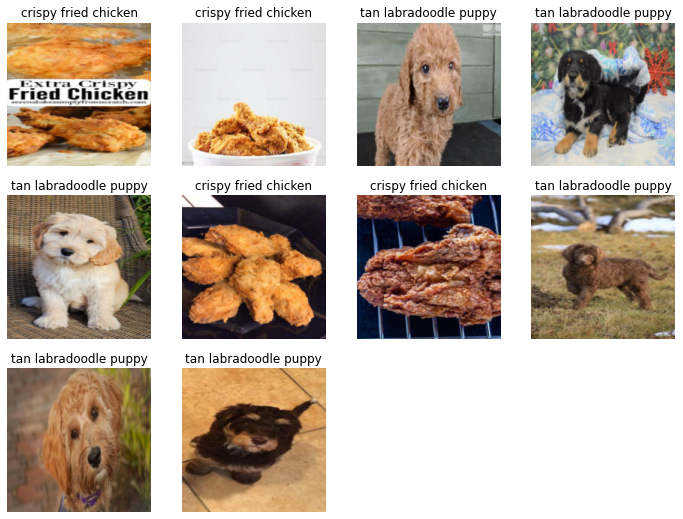

In [13]:
path2 = Path('02_chicken_or_not')

dls2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path2)

dls2.show_batch(max_n=10)

In [14]:
learn1 = vision_learner(dls1, resnet18, metrics=error_rate)
learn1.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.619709,0.017180,0.000000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.055256,0.007445,0.000000,00:02
1,0.028118,0.001610,0.000000,00:02
2,0.019318,0.000743,0.000000,00:02


In [15]:
learn2 = vision_learner(dls2, resnet18, metrics=error_rate)
learn2.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.950670,0.050288,0.012987,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.053409,0.037283,0.012987,00:02
1,0.026427,0.040388,0.012987,00:02
2,0.017061,0.037348,0.012987,00:02


Let's see how well each of these models does with this crispy looking puppy!

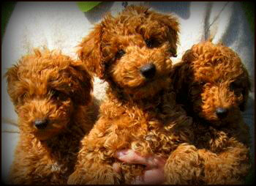

In [16]:
url = 'https://www.kentshilllabradoodles.com/labradoodlemaine/Images4/Kents%20Hill%203%20%20Labradoodle%20puppies%20for%20sale.jpg'
dest = '01_crispy_puppy.jpg'
download_url(url, dest)

im = Image.open(dest)
im.to_thumb(256, 256)

In [17]:
is_chicken,_,probs = learn1.predict(PILImage.create('01_crispy_puppy.jpg'))
print(f"Model 1 thinks this is a: {is_chicken}.")
print(f"Probability it's fried chicken: {probs[0]:.4f}")

This is a: labradoodle puppy.
Probability it's fried chicken: 0.0001


In [18]:
is_chicken,_,probs = learn2.predict(PILImage.create('01_crispy_puppy.jpg'))
print(f"Model 2 thinks this is a: {is_chicken}.")
print(f"Probability it's fried chicken: {probs[0]:.4f}")

This is a: tan labradoodle puppy.
Probability it's fried chicken: 0.0005


Let's generically look at any image that we want to upload from our local machine.  We've snipped each of the 9 images out of this meme, and run them through each of these 2 models.

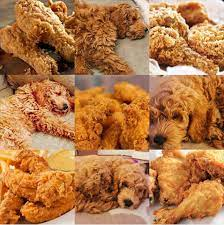

In [42]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

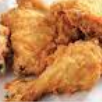

In [43]:
img = PILImage.create(uploader.data[0])
img.to_thumb(256, 256)

In [44]:
# predict using model 1
is_chicken,_,probs = learn1.predict(img)
print(f"Model 1 thinks this is a: {is_chicken}.")
print(f"Probability it's fried chicken: {probs[0]:.4f}")

# predict using model 2
is_chicken,_,probs = learn2.predict(img)
print(f"Model 2 thinks is a: {is_chicken}.")
print(f"Probability it's fried chicken: {probs[0]:.4f}")

Model 1 thinks this is a: fried chicken.
Probability it's fried chicken: 0.9915


Model 2 thinks is a: crispy fried chicken.
Probability it's fried chicken: 0.9978


Ultimately, every one of these 9 images from the meme have been correctly classified as either fried chicken or a labradoodle.  **Great success!**